# Практическое задание №2: Анализ логов

## Выполнил студент группы ББМО-01-23 Агасиев Максим Артурович

## Клонирование репозитория с логами для их последующего анализа

In [1]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 575 (delta 146), reused 136 (delta 133), pack-reused 401 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 9.60 MiB/s, done.
Resolving deltas: 100% (267/267), done.


# Задание регулярного выражения для парсинга логов

Пример лога, который необходимо распарсить:
```
20171223-22:15:29:633|Step_StandReportReceiver|30002312|onReceive action: android.intent.action.SCREEN_ON
```
Поля лога:

Символ "|" (Pipe) - выступает в качестве разделителя
- 20171223-22:15:29:633 - Time
- Step_StandReportReceiver - Component
- 30002312 - Pid
- onReceive action: android.intent.action.SCREEN_ON - Content

In [2]:
import re

pattern = re.compile(r'(\d{8}-\d{2}:\d{2}:\d{2}:\d{3})\|([^|]+)\|(\d+)\|(.*?)$')

# Создание базы данных

In [3]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

import sqlite3

db_path = './db/log-analysis.db'

connection = sqlite3.connect(db_path)

cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS LogTable")

cursor.execute("CREATE TABLE LogTable (id INTEGER PRIMARY KEY AUTOINCREMENT,\
              TimeStamp TIMESTAMP,Component VARCHAR(255),Pid INT,Content VARCHAR(255))")

connection.commit()

cursor.close()

connection.close()

# Парсинг лога и сохранение записей в БД

In [4]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM LogTable")

with open('./loghub/HealthApp/HealthApp_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = pattern.match(line)
        if log_match:
            timestamp = log_match.group(1)
            component = log_match.group(2)
            pid = int(log_match.group(3))
            content = log_match.group(4)
            values = (timestamp, component, pid, content)
            sql = "INSERT INTO LogTable (TimeStamp, Component, Pid, Content) VALUES (?, ?, ?, ?)"
            cursor.execute(sql, values)

connection.commit()
cursor.close()
connection.close()

# Чтение записей из БД

In [5]:
import pandas as pd

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM LogTable")
rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("id", "TimeStamp","Component", "Pid", "Content"))
log_df

,id,TimeStamp,Component,Pid,Content
0,1,20171223-22:15:29:606,Step_LSC,30002312,onStandStepChanged 3579
1,2,20171223-22:15:29:615,Step_LSC,30002312,onExtend:1514038530000 14 0 4
2,3,20171223-22:15:29:633,Step_StandReportReceiver,30002312,onReceive action: android.intent.action.SCREEN_ON
3,4,20171223-22:15:29:635,Step_LSC,30002312,processHandleBroadcastAction action:android.in...
4,5,20171223-22:15:29:635,Step_StandStepCounter,30002312,flush sensor data
...,...,...,...,...,...
1363,1364,20171223-23:57:42:147,Step_LSC,30002312,onExtend:1514044662000 0 0 0
1364,1365,20171223-23:57:42:443,Step_SPUtils,30002312,getTodayTotalDetailSteps = 1514044560000##721...
1365,1366,20171223-23:57:42:444,Step_SPUtils,30002312,setTodayTotalDetailSteps=1514044560000##7214##...
1366,1367,20171223-23:57:42:464,Step_ExtSDM,30002312,calculateCaloriesWithCache totalCalories=131208


# Построение графика распределения уровней логирования

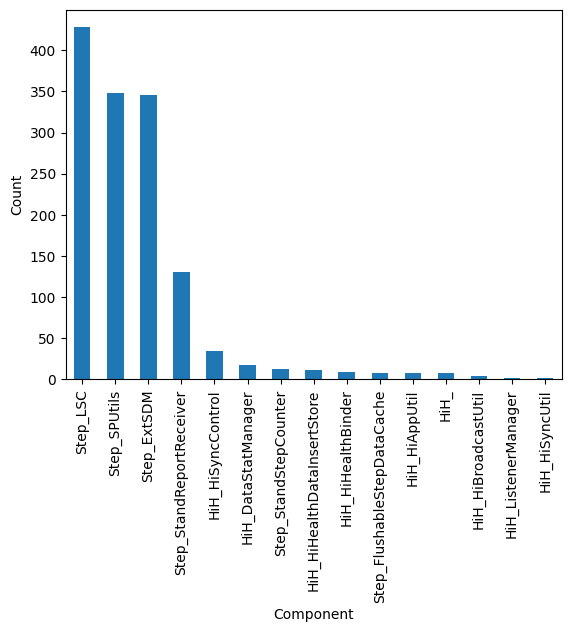

In [6]:
import matplotlib.pyplot as plt

components_distrib = log_df['Component'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Component')
plt.ylabel('Count')
plt.show()